#Import библиотек

In [0]:
import cv2, os, time, h5py
import numpy as np



import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import MaxPooling2D, Conv2D,  Input, Conv2DTranspose, concatenate, SpatialDropout1D, Conv1D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation, Reshape, MaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, CuDNNLSTM, CuDNNGRU, Bidirectional, SeparableConv1D, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import CosineSimilarity
from tensorflow.keras import backend as K
from tensorflow.keras import utils

In [0]:
from google.colab import drive
drive.mount('/content/drive')

#Распаковка файлов

In [0]:
!unzip /content/drive/My\ Drive/Test_Classification/test_task/test_proj.zip

Archive:  /content/drive/My Drive/Test_Classification/test_task/test_proj.zip
   creating: test_proj/
   creating: test_proj/test/
   creating: test_proj/test/43_cup_yogurt_blackberry/
  inflating: test_proj/test/43_cup_yogurt_blackberry/005093.jpg  
  inflating: test_proj/test/43_cup_yogurt_blackberry/005090.jpg  
  inflating: test_proj/test/43_cup_yogurt_blackberry/005054.jpg  
  inflating: test_proj/test/43_cup_yogurt_blackberry/005306.jpg  
  inflating: test_proj/test/43_cup_yogurt_blackberry/005063.jpg  
  inflating: test_proj/test/43_cup_yogurt_blackberry/004963.jpg  
  inflating: test_proj/test/43_cup_yogurt_blackberry/004959.jpg  
  inflating: test_proj/test/43_cup_yogurt_blackberry/005256.jpg  
  inflating: test_proj/test/43_cup_yogurt_blackberry/005265.jpg  
  inflating: test_proj/test/43_cup_yogurt_blackberry/005155.jpg  
  inflating: test_proj/test/43_cup_yogurt_blackberry/005111.jpg  
  inflating: test_proj/test/43_cup_yogurt_blackberry/005230.jpg  
  inflating: test_proj/

#Подключение репозитория из GitHub

In [0]:
!git clone https://github.com/sabeninvv/Curd2DNet.git

Cloning into 'Curd2DNet'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), done.


In [0]:
#"Упасть" в репозиторий Curd2DNet
%cd Curd2DNet

/content/Curd2DNet


In [0]:
#Проверка, что упали туда, куда надо
!pwd

/content/Curd2DNet


#Импорт модуля goToCurd из репозитория Curd2DNet

In [0]:
path_to_dir_Curd2DNet = None

try: 
  if path_to_dir_Curd2DNet:
    try:
      import sys
      sys.path.append(path_to_dir_Curd2DNet)
      import goToCurd
      print('Модуль goToCurd успешно подключен.')
    except:
      print('Введите корректный путь к сохранённому репозиторию Curd2DNet.') 
  else:
    import goToCurd
    print('Модуль goToCurd успешно подключен.')
except:
  print('Не найден путь к сохранённому репозиторию Curd2DNet.')
  print('Введите корректный путь к сохранённому репозиторию Curd2DNet.') 

Модуль goToCurd успешно подключен.


#Обработка данных

In [0]:
#Предобработка данных
#Кадрирование, изменение размера и перевод в Grey изображений
#Перевод изобрадений в тензор (150,150,2)
#
#pic_in_dir = False. Т.е. в главной директории есть поддиректории с изображениями
#pic_in_dir = True. Т.е. в главной директории есть только изображения
#num_pics_train, num_pics_test - список количества данных в каждом классе

main_dirpatch = '/content/test_proj/data'
num_pics_train, db = goToCurd.dataInputPreprocess(main_dirpatch, pic_in_dir = False)    

main_dirpatch = '/content/test_proj/test'
num_pics_test, db_test = goToCurd.dataInputPreprocess(main_dirpatch, pic_in_dir = False)  

:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
/content/test_proj/data/36_curd_strawberry Обработано элементов: 872
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
/content/test_proj/data/42_cup_yogurt_peach Обработано элементов: 1025
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
/content/test_proj/data/37_curd_cereals Обработано элементов: 777
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
/content/test_proj/data/43_cup_yogurt_blackberry Обработано элементов: 974
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
/content/test_proj/data/35_curd_raisins Обработано элементов: 997
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
/content/test_proj/test/36_curd_strawberry Обработано

In [0]:
#Создание выборки X_Train, y_Train, X_Test, y_Test.
#Балансирование выборки X_Train, y_Train.
#При балансирование, происходит перемешивание выборки и
#ограничение данных в каждом классе до slice_

X_Train, y_Train = goToCurd.makeXYdata(db, slice_ = min(num_pics_train))
X_Test, y_Test = goToCurd.makeXYdata(db_test, slice_ = None)
print(X_Train.shape, y_Train.shape)
print(X_Test.shape, y_Test.shape)

(3885, 150, 150, 2) (3885,)
(500, 150, 150, 2) (500,)


In [0]:
#Создание и компиляция модели по шаблону
#Подключение и загрузка весов из репозитория
#Проверка точности модели

model = goToCurd.createModel()
model = goToCurd.getWeightsModel(model, pathWeights=None)
loss, acc = model.evaluate(X_Test,  y_Test, verbose=2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
500/500 - 7s - loss: 0.4762 - acc: 0.9240


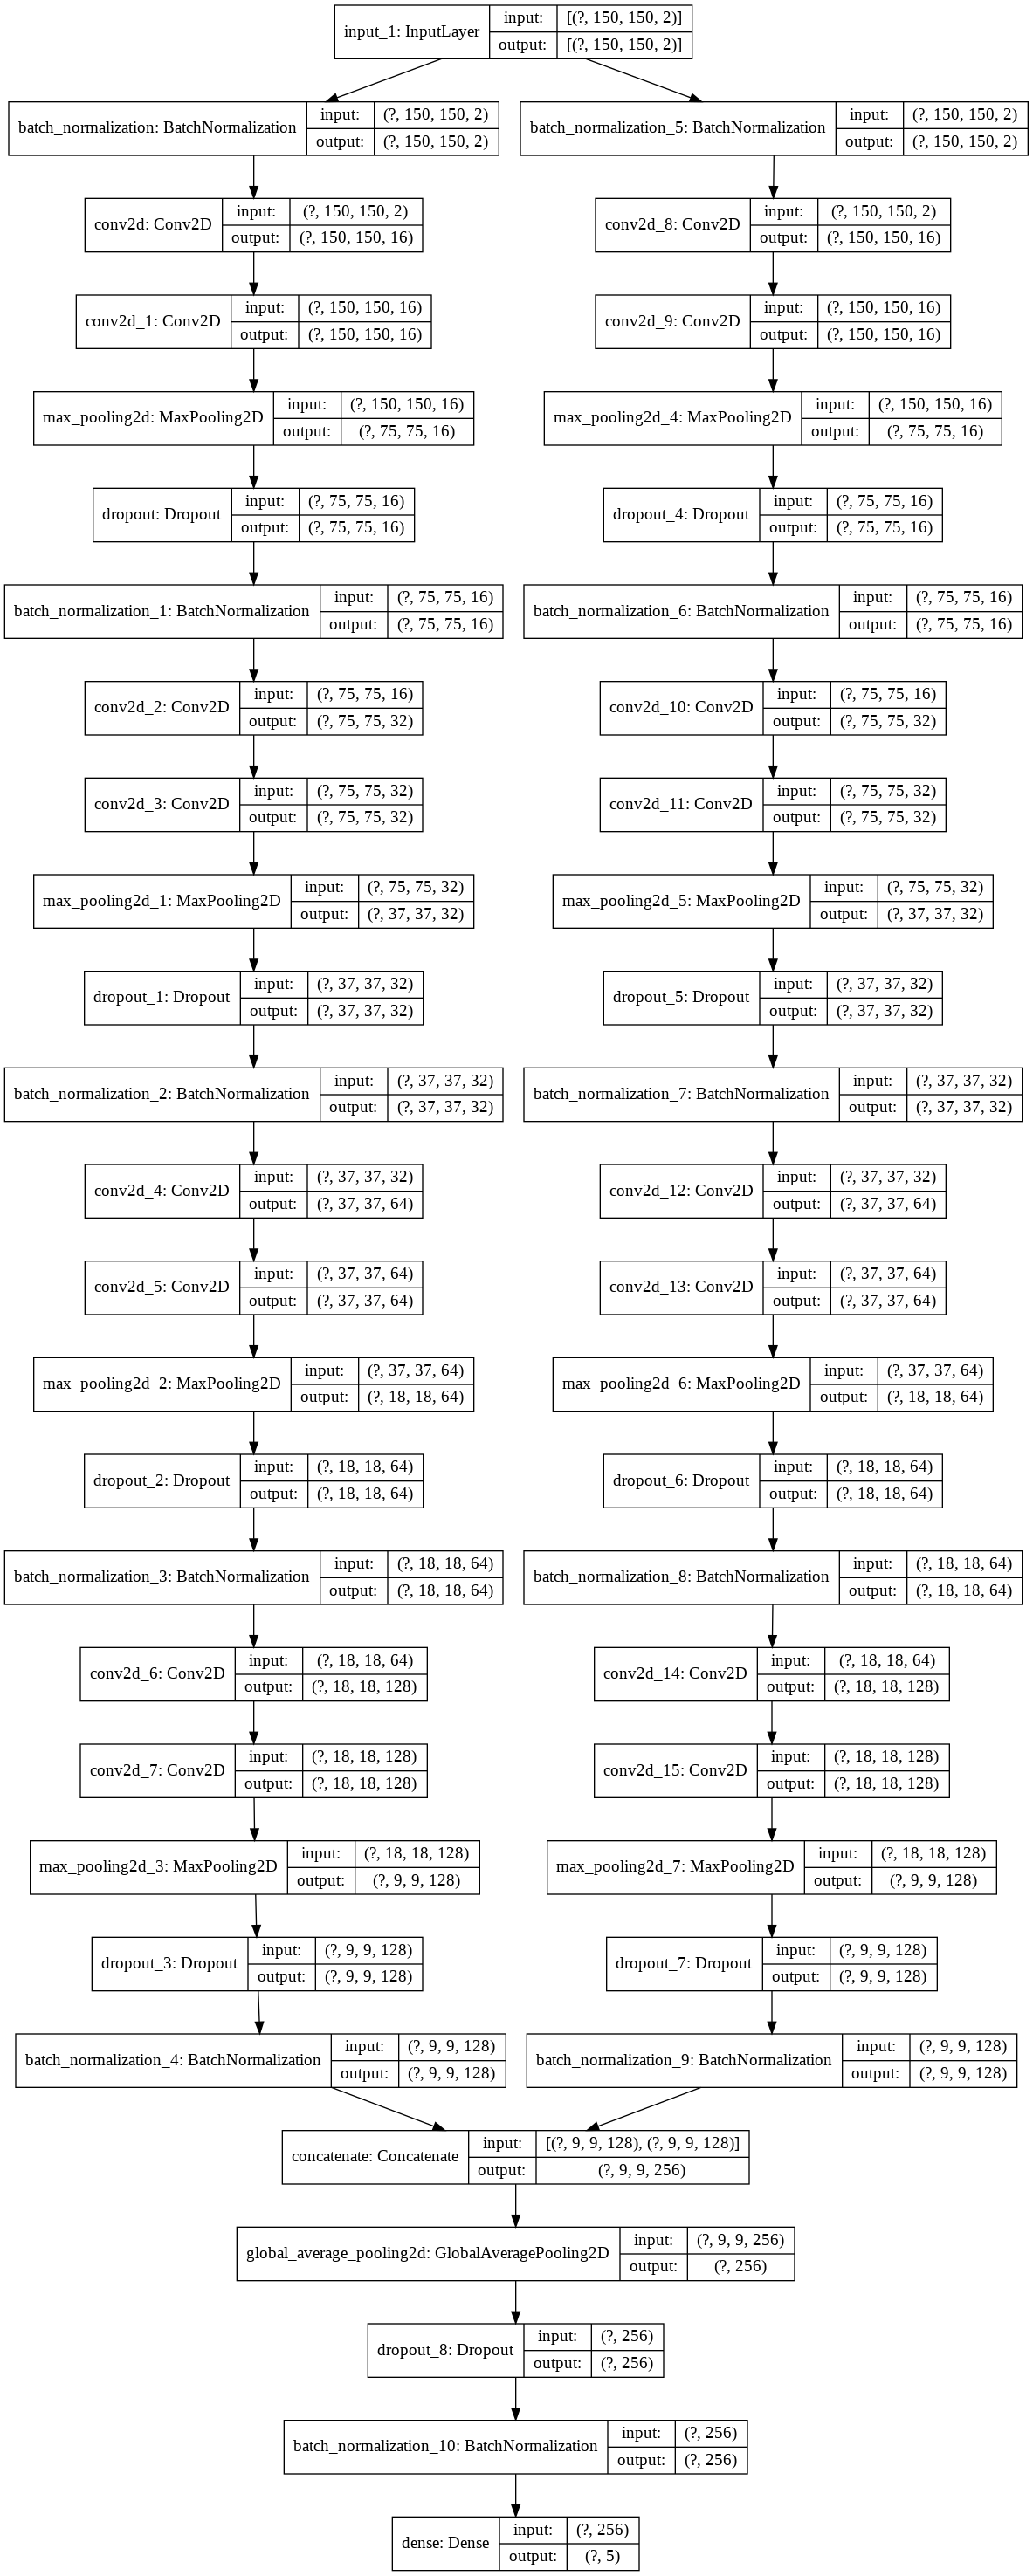

In [0]:
#Отображение архитектуры модели
utils.plot_model(model, show_shapes=True)

In [0]:
#Создание Confusion Matrix: 
#All по горизонтали - количество данных, 
#остальные ячейки - % predict. Те. сколько изображений этого класса 
#были отнесены сетью к данному классу по отношению к общему кол-ву изображений класса.
#
#Пример для X_Test, y_Test

goToCurd.getConfMatrix(model, X_Test, y_Test, num_pics_test)

Predicted,0,1,2,3,4,All
Actual,,,,,,
0,92.0,1.0,3.0,1.0,3.0,100.0
1,0.0,97.0,0.0,3.0,0.0,100.0
2,3.0,1.0,95.0,0.0,1.0,100.0
3,1.0,5.0,1.0,90.0,3.0,100.0
4,5.0,2.0,3.0,2.0,88.0,100.0
All,101.0,106.0,102.0,96.0,95.0,500.0


In [0]:
#Пример для X_Train_All, y_Train_All
X_Train_All, y_Train_All = goToCurd.makeXYdata(db, slice_ = None)

#Создание Confusion Matrix: 
#All по горизонтали - количество данных, 
#остальные ячейки - % predict. Те. сколько изображений этого класса 
#были отнесены сетью к данному классу по отношению к общему кол-ву изображений класса.
goToCurd.getConfMatrix(model=model, 
                       X_Test=X_Train_All, 
                       y_Test=y_Train_All, 
                       num_pics_test=num_pics_train)

Predicted,0,1,2,3,4,All
Actual,,,,,,
0,98.509,0.229,0.688,0.115,0.459,100.0
1,0.000,99.122,0.293,0.585,0.000,100.0
2,0.000,0.000,100.000,0.000,0.000,100.0
3,0.103,1.643,0.616,96.920,0.719,100.0
4,1.103,0.802,0.401,0.702,96.991,100.0
All,871.000,1042.000,796.000,958.000,978.000,4645.0
